## COP Arbitrage Base Model

#### All that's going on here:
1. Aggregating OpenEI energy use with TMY3 temperature data for all hours year long on selected locations
2. Sum daily energy load for DHW and Heating
3. Build 4 models of estimated annual thermal energy need:
    - Heat Pump only
    - Heat Pump with storage
        - overly optimistic, takes best COP over 24hr period and purchases all at that moment (assumes infinite storage capacity and heat pump capacity)
        - we get docked here in some locations because of standby losses associated with thermal storage (assuming 4%)
    - Resistive Heating
        - 98% efficient
    - Natural Gas
        - 85% efficient
4. Heat pump performance curves are based on the curve generated below based on SANDEN reported numbers.
    - operating on a CO2 refrigeration cycle
    - EWT of 50F (which is not realistic for thermal storage, likely EWT around room temp)
    - I did a lazy parabolic curve fit just as a proof of concept. Can be made less shit with ease. 



combine data from early Sensiblle Heat storage calcs and more recent findEnergyUse to map the benefit of thermal storage across America.



In [1]:
import pandas as pd
import datetime
import os
from glob import glob
import plotly.graph_objects as go
import plotly.express as px
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt


# globals
COE = 0.2

In [7]:


def create_df(finishString, shiftTime):
    
    update = []
    ### WILL NEED TO UDPATE PATH
    directory = os.path.join("c:\\", "/Users/voncronic/Desktop/GitHub/hansvonclemm.github.io/OL_data_for_watts_personal/data")
    for root,dirs,files in os.walk(directory):
        for file in files:
            if file.endswith(finishString):
                #print (file)

                li = file.split('_')
                city = li[2].split('.')[0]
                tmy3 = int(li[2].split('.')[-1])
                state = li[1]
                # print (tmy3)
                # print(city)
                path = "./data/" + file
                current = pd.read_csv(path)
                cleanDF = clean_datetime(current)
                
                tmyFileName = str(tmy3) + 'TYA.csv'
                
                
                tempData = pd.read_csv('./data/' + tmyFileName, skiprows=[0])
                tempList = tempData['Dry-bulb (C)'].tolist()
                cleanDF['DRY BULB (C)'] = tempList

                # heatNeed = get_gas_use(cleanDF, shiftTime)
                heatNeed = 1
                peakLoad = cleanDF['Gas:Facility [kW](Hourly)'].max() # this could be the size of HP
                
                # COP FUNCTION (from another slide) currently 150F SANDEN
                params = [3.61675824e+00,  6.29945053e-02, -1.18131867e-03]
                cleanDF['COP'] = (params[0] + params[1]*cleanDF['DRY BULB (C)'] + params[2]*cleanDF['DRY BULB (C)']**2 )
                
                cleanDF['HP_need'] = cleanDF['Gas:Facility [kW](Hourly)'] / cleanDF['COP']
                dailyMax = cleanDF.resample('24H').max()
                dailySum = cleanDF.resample('24H').sum()
                HP_max = dailySum['Gas:Facility [kW](Hourly)'].max() / 24
                sumAndMax = dailySum.join(dailyMax, rsuffix='_max')
                
                
                
                sumAndMax['storage_need'] = (sumAndMax['Gas:Facility [kW](Hourly)'] / sumAndMax['COP_max']) *1.04
                
                annualStorage = sumAndMax['storage_need'].sum()
                annualHP = sumAndMax['HP_need'].sum()
                annualResistive = sumAndMax['Gas:Facility [kW](Hourly)'].sum() / 0.98
                annualNG = sumAndMax['Gas:Facility [kW](Hourly)'].sum() / 0.85
                
                update.append([tmy3, city, state, peakLoad,HP_max, annualStorage, annualHP, annualResistive, annualNG])
                
    return pd.DataFrame(update, columns=['tmy3', 'city', 'state', 'peakLoad','HP_max', 'annualStorage', 'annualHP', 'annualResistive', 'annualNG'])

def to_C(F):
    C = (F-32) * (5/9)
    return (C)

def clean_datetime(df):
    pat = '(?P<month>\d{2})/(?P<day>\d{2})  (?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2})'
    exp = df['Date/Time'].str.extract(pat,expand=True)
    exp['hour'] = exp['hour'].replace(24,0)
    exp['year'] = 2014

    df = df.set_index(pd.to_datetime(exp))

    return df


In [8]:
new = create_df('LOW.csv', 12)
new['percentLess'] = new['annualStorage'] / new['annualHP']
new['moneySaved'] = (new['annualHP'] - new['annualStorage']) * COE
new

,tmy3,city,state,peakLoad,HP_max,annualStorage,annualHP,annualResistive,annualNG,percentLess,moneySaved
0,724699,Boulder-Broomfield-Jefferson,CO,8.119554,5.806781,3408.093166,3654.404529,13235.880589,15260.191738,0.932599,49.262273
1,723085,Norfolk,VA,3.982023,2.699524,786.909506,794.275907,3124.941809,3602.874085,0.990726,1.473280
2,724463,Kansas,MO,5.509993,3.455536,1260.276325,1299.576376,4815.122744,5551.553282,0.969759,7.860010
3,725090,Boston-Logan,MA,9.397890,6.313666,3818.716785,3911.249460,14574.142476,16803.128972,0.976342,18.506535
4,722110,Tampa,FL,0.342938,0.110122,203.724420,197.907079,886.871948,1022.511187,1.029394,-1.163468
5,702730,Anchorage,AK,10.208369,7.825157,6850.853193,7212.559249,22748.856752,26228.093667,0.949851,72.341211
6,726185,Augusta,ME,11.392054,8.377955,5423.081672,5934.302805,18578.099247,21419.455603,0.913853,102.244226
7,726410,Madison-Dane,WI,12.243027,8.327188,5543.696086,6485.263069,18636.869266,21487.213977,0.854814,188.313397
8,722280,Birmingham,AL,4.286480,2.548362,646.899604,679.802868,2653.679215,3059.536036,0.951599,6.580653
9,726797,Bozeman-Gallatin,MT,12.359991,8.629339,4991.512594,5944.855368,17674.194533,20377.306639,0.839636,190.668555


In [9]:

newHigh = create_df('HIGH.csv', 12)
newHigh['percentLess'] = newHigh['annualStorage'] / newHigh['annualHP']
newHigh['moneySaved'] = (newHigh['annualHP'] - newHigh['annualStorage']) * COE
newHigh

,tmy3,city,state,peakLoad,HP_max,annualStorage,annualHP,annualResistive,annualNG,percentLess,moneySaved
0,724930,Oakland,CA,13.155729,8.689445,6360.854248,6339.661386,26942.694501,31063.341895,1.003343,-4.238572
1,724463,Kansas,MO,20.348885,16.839887,7549.785022,7799.909995,29056.035698,33499.899981,0.967932,50.024995
2,724957,Santa,CA,16.109078,9.371394,6838.472529,6979.584608,28989.250818,33422.900943,0.979782,28.222416
3,724699,Boulder-Broomfield-Jefferson,CO,25.898259,19.757166,11826.937291,12817.369876,45608.833911,52584.302627,0.922727,198.086517
4,726410,Madison-Dane,WI,33.198401,29.242319,20017.581473,23425.582364,67085.048041,77345.114212,0.854518,681.600178
5,702730,Anchorage,AK,32.862769,26.870739,25326.366344,26677.184430,84444.050248,97359.022639,0.949364,270.163617
6,722784,Phoenix-Deer,AZ,10.435660,5.781586,2830.421690,2850.828822,12153.327685,14012.071919,0.992842,4.081426
7,726797,Bozeman-Gallatin,MT,31.898642,28.313989,17854.493041,21142.666928,63313.872916,72997.171126,0.844477,657.634777
8,722110,Tampa,FL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
9,722280,Birmingham,AL,19.660152,12.248637,4290.720382,4540.626568,17617.829800,20312.321417,0.944962,49.981237


In [10]:
# SANDEN HEAT PUMP CURVE FIT
# CURVE 
# Data taken from SANDEN tests run on their SANCO2 highly efficient heat pumps
T = [-13, -4, 5, 14, 23, 32, 41, 50, 59, 68, 77, 86, 95, 104]
cop_140F = [1.7, 2.0, 2.2, 2.5, 2.9, 3.2, 3.9, 4.7, 4.8, 5.2, 5.0, 4.6, 4.3, 4.0]
cop_150F = [1.7, 1.9, 2.2, 2.6, 3.0, 3.4, 3.9, 4.3, 4.5, 4.8, 4.6, 4.4, 4.2, 4.1]
cop_160F = [1.5, 1.9, 2.1, 2.5, 2.9, 3.3, 3.7, 4.0, 4.2, 4.3, 4.3, 4.2, 4.1, 4.0]

df = pd.DataFrame(list(zip(T, cop_140F, cop_150F, cop_160F)), 
                  columns = ['ambient_F', '140F', '150F', '160F'])

df['ambient_C'] = to_C(df['ambient_F'])

fig = go.Figure()


fig.add_trace(go.Scatter(x = df['ambient_C'].tolist(), y = cop_140F, name = '140F SET TEMP'))
fig.add_trace(go.Scatter(x = df['ambient_C'].tolist(), y = cop_150F, name = '150F SET TEMP'))
fig.add_trace(go.Scatter(x = df['ambient_C'].tolist(), y = cop_160F, name = '160F SET TEMP'))

fig.add_annotation(y=max(cop_140F), x = 20, text = 'COP 5.2')

fig.update_layout(title='HEAT PUMP COP w.r.t AMBIENT TEMPERATURE')
fig.layout.xaxis.title = 'Outside Temperature [F]'
fig.layout.yaxis.title = 'COP'

fig.show()

[ 3.61675824e+00  6.29945053e-02 -1.18131867e-03]


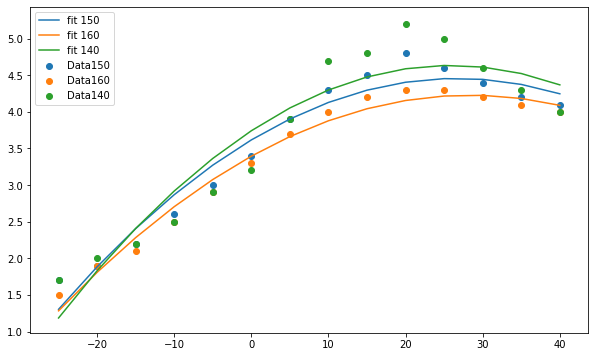

In [13]:
# in the interest of learning, let's figure this out. here's a straight line fit

# now I have my data, should fit it to a curve. 


def func(x, a, b, c):
    return (a + (b*np.array(x)) + (c*(np.array(x)**2)))
    # form y = a + bx + cx^2

xdata = df['ambient_C'].tolist()
ydata = df['150F'].tolist()
ydata2 = df['160F'].tolist()
ydata3 = df['140F'].tolist()

params, params_covariance = optimize.curve_fit(func, xdata, ydata, p0=[100,20, 10])
params2, params_covariance2 = optimize.curve_fit(func, xdata, ydata2, p0=[100,20, 10])
params3, params_covariance3 = optimize.curve_fit(func, xdata, ydata3, p0=[100,20,10])

print(params)

plt.figure(figsize=(10,6))

plt.scatter(xdata, ydata, label ='Data150')
plt.scatter(xdata, ydata2, label ='Data160')
plt.scatter(xdata, ydata3, label ='Data140')
plt.plot(xdata, func(xdata, params[0], params[1], params[2]), label = 'fit 150')
plt.plot(xdata, func(xdata, params2[0], params2[1], params2[2]), label = 'fit 160')
plt.plot(xdata, func(xdata, params3[0], params3[1], params3[2]), label = 'fit 140')

plt.xlabel
plt.legend(loc='best')

plt.show()

# close enough. 

### What we need: 
We need to generate a realistic equation for calculating COP based on EWT and LWT, given some GPM and T-s diagram for the refrigerant used. 



For reference here's the T-s diagram for CO2

![](co2TS.png)